In [4]:
import random
import statsmodels
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from scipy import stats
import unicodedata
from sklearn.preprocessing import scale
import os
from datetime import datetime

In [66]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.ticker as mtick

What I should think of when interpreting the results:

Factors that influence the spread:
- introducing preventative measures, people learnign about the importance thereof
- reinfections (posible? I think yes)

In [108]:
colors={
    'orange' : "#ef7626",
    "lightorange": "#f59b5f",
    "darkgrey": "#333333",
    'grey' : "#545454",
    "lightgrey": "#dddddd",
    "yellow" : '#ffd666',
    "sel": "#00695e",
    "lightsel": "#7bc7bf",
}

In [8]:
#kaggle datasets
kg = {}
for i,f in enumerate(os.listdir("data/novel-corona-virus-2019-dataset")):
    #print(pd.read_csv(os.path.join("data/novel-corona-virus-2019-dataset",f)).head())
    print(f)
    kg[i] = pd.read_csv(os.path.join("data/novel-corona-virus-2019-dataset",f))

COVID19_line_list_data.csv
COVID19_open_line_list.csv
covid_19_data.csv
time_series_covid_19_confirmed.csv
time_series_covid_19_deaths.csv
time_series_covid_19_recovered.csv


# Part I: Epidemic dynamics and factors that influence it

In [76]:
select = "Poland" 
#select = "Saint Vincent and the Grenadines"

In [77]:
import matplotlib.dates as mdates

names = ["pierwsza infekcja", 
         "ogłoszenie zamknięcia szkół",
         "zakaz zgromadzeń >50 osób oraz zawieszenie międzynarowdowych połączeń lotniczych i kolejowych",
         "zamknięcie granic", ]
dates = ["2020-03-04", "2020-03-12", "2020-03-13", "2020-03-15"] #TODO
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

In [107]:
fig, ax = plt.subplots(figsize=(14, 8), constrained_layout=True)
ax.set(title="Istotne zdarzenia")

plt.bar(
    pd.Series(kg[3][kg[3]["Country/Region"] == select].iloc[:,4:].columns).apply(pd.to_datetime),
    kg[3][kg[3]["Country/Region"] == select].iloc[0,4:],
    #y=kg[3][kg[3]["Country/Region"] == select].iloc[:,4:].index
    color=colors['orange'],
    #width=0.9
)

# Choose some nice levels
levels = np.tile([-10, -20, -30, -40],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)
plt.setp(markerline, mec="k", mfc="w", zorder=3, visible=False) #marker
plt.setp(stemline, color=colors['lightorange'])
#markerline.set_ydata(np.zeros(len(dates))) #shift marker

#annotate
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, names, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

ax.set_ylim((-50, 200))
#plt.plot([0,0], [0,100], 'k-', lw=2)
plt.axhline(0, color=colors['grey'])
    
# format xaxis
ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=1))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%d %b"))
plt.setp(ax.get_xticklabels(), rotation=90, ha="left") 

ax.set_ylabel("number of cases")
#ax.set_xlabel("number of cases")

plt.grid(axis="y",which="major", color=colors['lightgrey'])

# remove y axis and spines
#ax.get_yaxis().set_visible(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
    
ax.spines['bottom'].set_color(colors['grey'])
ax.spines['top'].set_color(colors['grey']) 
ax.spines['right'].set_color(colors['grey'])
ax.spines['left'].set_color(colors['grey'])
ax.tick_params(axis='x', colors=colors['darkgrey'])
ax.tick_params(axis='y', colors=colors['darkgrey'])
ax.yaxis.label.set_color(colors['darkgrey'])
ax.xaxis.label.set_color(colors['darkgrey'])
ax.title.set_color(colors['darkgrey'])

ax.margins(y=0.1)

plt.show()

#### TODO:
- overlay GB to show the worst case scenario

# Part II: symptoms and infection characteristics

In [88]:
def rename_symptom(s):
    if s in ("feaver", "high fever", "feve\\", "mild fever"):
        return "fever"
    if s in ("myalgia", "muscle aches", "muscle pain", "sore body", "myalgias", "muscle cramps", "joint pain", "aching muscles"):
        return "muscle or joint ache"
    if s in ("breathlessness", "respiratory distress", "difficult in breathing", "difficulty breathing", "dyspnea", "shortness of breath"):
        return "difficulty breathing"
    if s in ("cough with sputum", "mild cough", "coughing"):
        return "cough"
    if s in ("flu", "flu symptoms"):
        return "malaise"
    if s in ( "sore throat", "itchy throat", "throat pain"):
        return "throat discomfort"
    if s == "chill":
        return "chills"
    if s in ("nausea", "vomiting"):
        return "nausea or vomiting"
    else:
        return s


In [152]:
d = pd.melt(kg[0].symptom.dropna().str.split(",",expand=True)).value.dropna().str.strip()\
    .apply(rename_symptom)\
    .value_counts()
total_reported = len(kg[0].symptom.dropna())

In [153]:
fig, ax = plt.subplots(figsize=(8,8), constrained_layout=True)
plt.barh(d[d>2].index, width = d[d>2].apply(lambda x: x/total_reported*100), color=colors["orange"])
plt.gca().invert_yaxis()

ax.set_xlabel("% cases with reported symptoms")
ax.set(title="Najczęstsze objawy zakażenia")
#ax.set_xlabel("number of cases")

plt.grid(axis="x",which="major")
ax.xaxis.set_major_formatter(mtick.PercentFormatter())

# remove y axis and spines
#ax.get_yaxis().set_visible(False)
for spine in ["top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)

for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_color(colors['grey'])
    
ax.tick_params(axis='x', colors=colors['darkgrey'])
ax.tick_params(axis='y', colors=colors['darkgrey'])
ax.yaxis.label.set_color(colors['darkgrey'])
ax.xaxis.label.set_color(colors['darkgrey'])
ax.title.set_color(colors['darkgrey'])
ax.xaxis.set_tick_params(size=0)
plt.show()

# TODO: this needs to be % total cases with reported symptoms

### What are the variables that influence the likelihood of contracting an infection?

1. Sex

In [154]:
d = kg[1].sex.dropna().str.lower()
d = d[[i in ("male", "female") for i in d]]
#d.value_counts()
d = d.map({"male": "mężczyzna", "female":"kobieta"})

In [238]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)

plt.bar(d.value_counts().index, height = d.value_counts(), width = 0.5, color=colors["orange"])

#ax.set_xlabel("%")
ax.set(title="Kobiety i mężczyźni wśród zakażonych")
ax.set_ylabel("liczba zakażeń")

plt.grid(axis="y",which="major")
#ax.xaxis.set_major_formatter(mtick.PercentFormatter())

# remove y axis and spines
#ax.get_yaxis().set_visible(False)
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_color(colors['grey'])

ax.tick_params(axis='x', colors=colors['darkgrey'])
ax.tick_params(axis='y', colors=colors['darkgrey'])
ax.yaxis.label.set_color(colors['darkgrey'])
ax.xaxis.label.set_color(colors['darkgrey'])
ax.title.set_color(colors['darkgrey'])
ax.yaxis.set_tick_params(size=0)
ax.xaxis.set_tick_params(size=0)

plt.show()


In [157]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
nobs = len(kg[1].sex.dropna())
count = (kg[1].sex.dropna() == "Male").sum()
expected = .5
stat, pval = proportions_ztest(count, nobs, expected)
print('{0:0.3f}'.format(pval))
print(pval, stat)

0.000
0.0 -314.49801775941796


So it seems that there might be more males infected



2. Age
Do more older people get sick than younger people?



Perhaps: more people over 20 years old (uncorrected for the distribution of ages in respctive countries) TODO: correct for distribution of ages in respective countries to test if 

Unaccounted for:
- population distribution in each country - plot per country and overlay with pop distribution. Will allow to answer: (1. do older people actually die more) 
- higher % of older people may get diagnosed because of their more severe condition. Young people have light symptoms; some may even not notice that they're sick. 



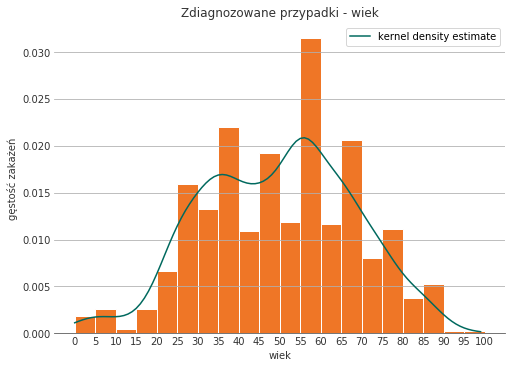

In [237]:
fig, ax = plt.subplots(figsize=(7,5), constrained_layout=True)


bins = np.arange(0,105,5)
plt.hist(kg[0].age.dropna(), density=1, align='mid', color = colors["orange"], edgecolor = "w", bins = bins)
#ax.set_xlabel("%")
ax.set_xticks(bins)
ax.set(title="Zdiagnozowane przypadki - wiek")
ax.set_xlabel("wiek")
ax.set_ylabel("gęstość zakażeń")


plt.grid(axis="y",which="major")#,color=colors['grey'])

#ax.xaxis.set_major_formatter(mtick.PercentFormatter())

from scipy.stats import gaussian_kde
density = gaussian_kde(kg[0].age.dropna())
xs = np.arange(0,100,1)
#density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs), color=colors['sel'], label="kernel density estimate") #density -> counts?

ax.legend()

# remove y axis and spines
#ax.get_yaxis().set_visible(False)
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_color(colors['grey'])

ax.tick_params(axis='x', colors=colors['darkgrey'])
ax.tick_params(axis='y', colors=colors['darkgrey'])
ax.yaxis.label.set_color(colors['darkgrey'])
ax.xaxis.label.set_color(colors['darkgrey'])
ax.title.set_color(colors['darkgrey'])
ax.yaxis.set_tick_params(size=0)
ax.xaxis.set_tick_params(size=0)

plt.show()

### What about the things that make it more likely that you die if you are infected?

1. Sex
2. Age

#### No data to answet this